In [228]:
import torch 
import pandas as pd 
import torch.nn as nn 
from torch.utils.data import random_split, DataLoader, TensorDataset 
import torch.nn.functional as F 
import numpy as np 
import torch.optim as optim 
from torch.optim import AdamW 
import random
import matplotlib.pyplot as plt
import seaborn as sns

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


In [229]:
df = pd.read_csv('Данные.csv', sep=';')

In [230]:
df.head()

,k,lu,P0,I,gamma,sgamma,r,Psat,Lsat,loptim,lres,loptim/lres,Psat/Pall,Lsat/lu,f,rho,P0/Pall
0,3.89,3.69,12800000.0,80.0,2650.0,0.0,0.0001,1.430000e+08,18.5,2.261250e-08,2.257770e-08,0.001542,0.00132,5.01,0.736,0.000965,1.180000e-04
1,3.89,3.69,12800.0,80.0,1000.0,0.0,0.0001,9.800000e+07,16.7,1.585280e-07,1.580440e-07,0.003065,0.00240,4.52,0.736,0.002550,3.130000e-07
2,3.98,3.69,150000.0,500.0,2830.0,0.0,0.0001,1.130000e+09,20.3,2.061380e-08,2.057220e-08,0.002024,0.00156,5.49,0.735,0.001690,2.070000e-07
3,3.98,3.69,1500000.0,500.0,3160.0,0.0,0.0001,1.100000e+09,18.3,1.648760e-08,1.645770e-08,0.001814,0.00136,4.96,0.735,0.001510,1.850000e-06
4,3.98,3.69,150000.0,500.0,2650.0,0.0,0.0001,1.180000e+09,19.4,2.356200e-08,2.351110e-08,0.002164,0.00175,5.25,0.735,0.001800,2.210000e-07


In [231]:
df = df.dropna()

In [232]:
l = len(df)

In [233]:
df = df[df['Psat/Pall']<0.008]

In [234]:
df['log'] = np.log(df[['Psat/Pall']])
df['log0'] = np.log(df['P0']/df['I']/df['gamma']/511000)
df['optim'] = df['loptim/lres']/df['Psat/Pall']
df['Lsat/lu'] = np.log(df['Lsat/lu'])

In [235]:
df = df[df['optim']<2.5]

In [236]:
len(df)/l

0.9296040226272785

In [237]:
df['optim'] = df['loptim/lres']/df['rho']

In [238]:
df['optim'] = (df['optim'])

In [239]:
df1 = df.drop(columns=['P0', 'optim', 'P0/Pall', 'Psat', 'Lsat', 'loptim','lres', 'loptim/lres', 'Psat/Pall', 'Lsat/lu', 'f', 'rho', 'log'])

In [240]:
df1

,k,lu,I,gamma,sgamma,r,log0
0,3.89,3.69,80.0,2650.0,0.0,0.0001,-9.043511
1,3.89,3.69,80.0,1000.0,0.0,0.0001,-14.976706
2,3.98,3.69,500.0,2830.0,0.0,0.0001,-15.388374
3,3.98,3.69,500.0,3160.0,0.0,0.0001,-13.196085
4,3.98,3.69,500.0,2650.0,0.0,0.0001,-15.322657
...,...,...,...,...,...,...,...
1586,2.91,3.37,7000.0,2450.0,0.0,0.0005,-18.011076
1587,1.77,3.37,50.0,283.0,0.0,0.0005,-15.531475
1588,1.25,3.37,5000.0,949.0,0.0,0.0005,-17.737771
1589,1.83,3.37,50.0,775.0,0.0,0.0005,-16.516077


In [241]:
df2 = df.drop(columns=[ 'k', 'lu', 'I', 'gamma', 'sgamma', 'r', 'log0', 'P0', 'P0/Pall', 'loptim','lres', 'loptim/lres', 'Psat/Pall', 'Lsat', 'f', 'rho', 'Psat'])

In [242]:
df2

,Lsat/lu,log,optim
0,1.611436,-6.630124,1.598041
1,1.508512,-6.032287,1.201894
2,1.702928,-6.463069,1.197420
3,1.601406,-6.600271,1.201364
4,1.658228,-6.348139,1.202222
...,...,...,...
1586,1.996060,-7.132150,0.796190
1587,1.780024,-6.489045,1.199050
1588,1.652497,-6.676644,0.797769
1589,2.674149,-7.740165,0.800961


In [243]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df1, df2, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)



In [244]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

scaler2 = MinMaxScaler()
scaler2.fit(y_train)

y_train = scaler2.transform(y_train)
y_test = scaler2.transform(y_test)
y_val = scaler2.transform(y_val)


In [245]:

X_train = torch.Tensor(X_train) 
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

train_set = TensorDataset(X_train, y_train) 
validate_set = TensorDataset(X_val, y_val) 
test_set = TensorDataset(X_test, y_test) 


# Create Dataloader to read the data within batch sizes and put into memory. 
train_loader = DataLoader(train_set, batch_size = 64, shuffle = True) 
validate_loader = DataLoader(validate_set, batch_size = 20) 
test_loader = DataLoader(test_set, batch_size = 1)

In [246]:
train_dataset_array = next(iter(train_loader))[0].numpy()
train_dataset_array 

array([[0.33110368, 0.55518395, 0.6226415 , 0.0677541 , 0.        ,
        0.13043478, 0.83860534],
       [0.9397993 , 0.85953176, 1.        , 0.31383172, 0.        ,
        0.42028984, 0.545985  ],
       [0.5618729 , 0.27090302, 0.09433962, 0.1703784 , 0.        ,
        0.2753623 , 0.32036537],
       [0.5250836 , 0.93645483, 0.08176101, 0.31383172, 0.        ,
        0.13043478, 0.5225734 ],
       [0.9799331 , 0.2173913 , 0.8742138 , 0.77428675, 0.        ,
        0.13043478, 0.6709657 ],
       [0.06688963, 0.90301   , 0.05660377, 0.0677541 , 0.        ,
        0.5652174 , 0.33718285],
       [0.20735785, 0.74916387, 0.08176101, 0.2807271 , 0.1       ,
        0.02898551, 0.74127436],
       [0.03344481, 0.46488294, 0.09433962, 0.09203082, 0.        ,
        0.11594203, 0.37697557],
       [0.04682274, 0.5652174 , 0.6226415 , 0.26267004, 1.        ,
        0.2753623 , 0.67089766],
       [0.8896321 , 0.3645485 , 0.00377358, 0.01420539, 0.2       ,
        0.42028984, 0.8

In [247]:
# Define model parameters 
input_size = list(X_train.shape)[1]   
output_size = list(y_train.shape)[1]  



# Define neural network 
class Network(nn.Module): 
    def __init__(self, input_size, output_size, init_form="normal"): 
        super().__init__() 
        self.conv_stack = nn.Sequential(
        nn.Linear(input_size, 50), 
        nn.Tanh(),
        nn.Linear(50, 50),
        nn.Tanh(), 
        nn.Linear(50, 30),
        nn.Dropout(p=0.1),
        nn.Tanh(),
        nn.Linear(30, 30),
        nn.Dropout(p=0.1),
        nn.Tanh(),
        nn.Linear(30, output_size) )
        self.init_form = init_form
        if self.init_form is not None:
            self.init()

    def forward(self, x): 
        return self.conv_stack(x)
    
        # xavier weight initialization
    def init(self):
        sigmoid_gain = torch.nn.init.calculate_gain("tanh")
        for child in self.conv_stack.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.xavier_normal_(child.weight,
                                                 gain=sigmoid_gain)
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.xavier_uniform_(child.weight,
                                                  gain=sigmoid_gain)
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()

In [248]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_epoch(model,
                optimizer,
                criterion,
                train_loader):
    loss_history = []
    for batch in train_loader: 
        optimizer.zero_grad()
        x_train, y_train = batch # parse data
        x_train, y_train = x_train.to(device), y_train.to(device) # compute on gpu
        y_pred = model(x_train) # get predictions
        loss = criterion(y_pred, y_train) # compute loss
        loss_history.append(loss.cpu().detach().numpy()) # write loss to log
        loss.backward()
        optimizer.step()
    return loss_history

In [249]:
def validate(model,
             criterion,
             val_loader):
    cumloss = 0
    loss_history = []
    with torch.no_grad():
        for batch in val_loader:
            x_train, y_train = batch # parse data
            x_train, y_train = x_train.to(device), y_train.to(device) # compute on gpu
            y_pred = model(x_train) # get predictions
            loss = criterion(y_pred, y_train) # compute loss
            loss_history.append(loss.cpu().detach().numpy()) # write loss to log
            cumloss += loss
    return cumloss / len(val_loader), loss_history # mean loss and history

In [250]:
from tqdm import tqdm

def train_model(model, optimizer, model_name=None, n_epochs=5):
  
    criterion = nn.MSELoss().to(device)

    train_history = {}
    train_history['model_name'] = model_name
    train_history['loss_on_train'] = []
    train_history['loss_on_test'] = []

    for epoch in tqdm(range(n_epochs)):
        loss_on_train = train_epoch(model,
                                    optimizer,
                                    criterion,
                                    train_loader)
        _, loss_on_test = validate(model,
                                   criterion,
                                   validate_loader)
        train_history['loss_on_train'].append(np.mean(loss_on_train))
        train_history['loss_on_test'].append(np.mean(loss_on_test))
        scheduler.step()
    return train_history

In [251]:
def exponential_smoothing(scalars, weight):  
    last = scalars[0]  
    smoothed = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  
        smoothed.append(smoothed_val)                        
        last = smoothed_val                                 

    return smoothed


def plot_history(history, n_epochs=5, smooth_val=0.9):
    fig, ax =  plt.subplots(3, 1, figsize=(12, 14))
    for stage_idx, (stage_lbl, stage_title) in enumerate(
        zip(['loss_on_train', 'loss_on_test'],
            ['train loss', 'test loss'])):
        # plot history on each learning step
        epoch_len = len(history[stage_lbl])//n_epochs
        full_stage_len = len(history[stage_lbl])
        ax[stage_idx].plot(exponential_smoothing(history[stage_lbl], smooth_val),
                           label='smoothed',
                           color='m')
        ax[stage_idx].plot(history[stage_lbl],
                           label='raw',
                           alpha=0.2,
                           color='c')
        ax[stage_idx].set_title(stage_title)
        ax[stage_idx].set_xlabel('epochs')
        ax[stage_idx].set_ylabel('loss')
        epochs_ticks_positions = np.arange(stop=full_stage_len+1,
                                           step=epoch_len)
        ax[stage_idx].set_xticks(epochs_ticks_positions)
        ax[stage_idx].set_xticklabels(np.arange(n_epochs+1))
        ax[stage_idx].legend()

        # plot mean train and test loss combined
        mean_loss_on_epoch = [np.mean(history[stage_lbl][i:i+epoch_len]) \
                              for i in range(0, full_stage_len, epoch_len)]
        std_loss_on_epoch = [np.std(history[stage_lbl][i:i+epoch_len]) \
                              for i in range(0, full_stage_len, epoch_len)]

        ax[2].set_title('\nAverage loss per epoch')
        ax[2].errorbar(np.arange(n_epochs) + stage_idx / 30.,
                       mean_loss_on_epoch,
                       yerr=std_loss_on_epoch,
                       capsize=5,
                       fmt="X--",
                       label=stage_title)
        ax[2].set_xticks(np.arange(5))
        ax[2].set_xticklabels(np.arange(5))
        ax[2].set_xlabel('epochs')
        ax[2].set_ylabel('loss')
        ax[2].legend()

    fig.suptitle(history['model_name'], fontsize=24)
    plt.show()

In [252]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


set_random_seed(42)

model = Network(input_size,output_size).to(device) 
optimizer = optim.AdamW(model.parameters(), lr=0.01)

lambda1 = lambda epoch: 0.99 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1, last_epoch = -1)

n_epochs = 1000
history = train_model(model, optimizer, model_name='model', n_epochs=n_epochs)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.78it/s]


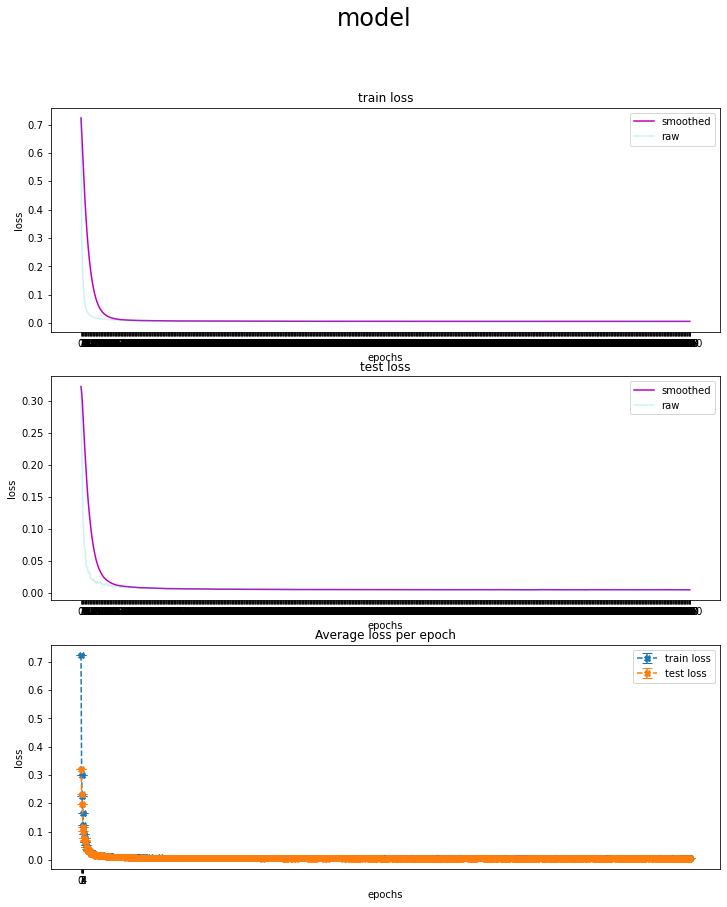

In [253]:
plot_history(history, n_epochs=n_epochs)


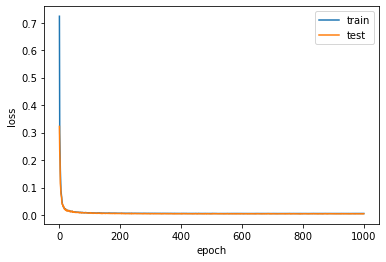

In [254]:
plt.plot(range(1,n_epochs+1), (history['loss_on_train']), label='train')
plt.plot(range(1,n_epochs+1), (history['loss_on_test']), label='test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [255]:
model.eval()

Network(
  (conv_stack): Sequential(
    (0): Linear(in_features=7, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=30, bias=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): Tanh()
    (7): Linear(in_features=30, out_features=30, bias=True)
    (8): Dropout(p=0.1, inplace=False)
    (9): Tanh()
    (10): Linear(in_features=30, out_features=3, bias=True)
  )
)

In [256]:
def relative_root_mean_squared_error(true, pred):
    num = np.sum(np.square(true - pred))
    den = np.sum(np.square(true))
    squared_error = num/den
    rrmse_loss = np.sqrt(squared_error)
    return rrmse_loss


def test(model, val_loader):
    cumloss1 = 0
    cumloss2 = 0
    cumloss3 = 0
    l1 = []
    l2 = []
    l3 = []
    with torch.no_grad():
        for batch in val_loader:
            x_train, y_train = batch # parse data
            x_train, y_train = x_train.to(device), y_train.to(device) # compute on gpu
            y_pred = model(x_train) # get predictions
            y_pred = scaler2.inverse_transform(y_pred.cpu().detach().numpy())
            y_train = scaler2.inverse_transform(y_train.cpu().detach().numpy())
            loss1 = relative_root_mean_squared_error(np.exp(y_pred[0][0]), 
                                                    np.exp(y_train[0][0])) # compute loss
            loss2 = relative_root_mean_squared_error(np.exp(y_pred[0][1]), 
                                                    np.exp(y_train[0][1]))
            loss3 = relative_root_mean_squared_error((y_pred[0][2]), 
                                                    (y_train[0][2]))
            cumloss1 += loss1
            cumloss2 += loss2
            cumloss3 += loss3
            l1.append(loss1)
            l2.append(loss2)
            l3.append(loss3)
    return cumloss1 / len(val_loader), cumloss2 / len(val_loader), cumloss3 / len(val_loader), l1, l2, l3


l = test(model, test_loader)
print('acc for Lsat=', l[0],'\n' 'acc for Psat=', l[1], '\n' 'acc for optim=', l[2])

acc for Lsat= 0.07444017437425114 
acc for Psat= 0.1344079938905968 
acc for optim= 0.18338023010000068


Text(0.5, 1.0, 'Lsat error')

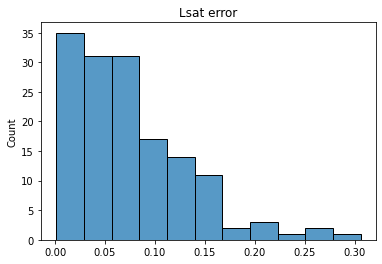

In [257]:
sns.histplot(l[3])
plt.title("Lsat error")

Text(0.5, 1.0, 'Power error')

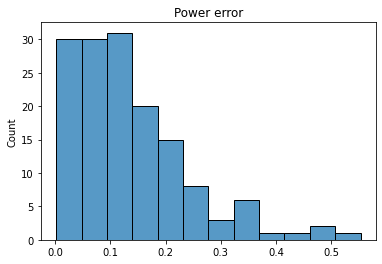

In [258]:
sns.histplot(l[4])
plt.title("Power error")

In [259]:
pd.Series(l[4]).sort_values()
#scaler.inverse_transform(np.array([X_test[103].cpu().detach().numpy()]))

122    0.001776
67     0.002290
35     0.002593
110    0.003047
141    0.005712
         ...   
19     0.384689
2      0.431483
33     0.463424
104    0.495667
24     0.553373
Length: 148, dtype: float32

Text(0.5, 1.0, 'optim error')

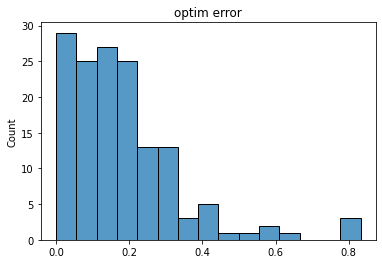

In [260]:
sns.histplot(l[5])
plt.title("optim error")

In [261]:
from scipy.special import jv

X = pd.DataFrame({'k':[2.13], 'lu':[2.8], 'I':[53], 'gamma':[300], 'sgamma':[0.0002], 
                  'r':[0.00012], 'log0':[10]})

ksi = X['k']**2/(1+X['k']**2/2)/4
f = jv(0,ksi)-jv(1,ksi)

rho = 1/2/(X['gamma'])*(X['I']/X['r']**2/np.pi/4/np.pi/17000*(X['lu']/100*X['k']*f)**2)**(1/3)
X['log0'] = np.log(X['log0']/X['I']/X['gamma']/511000)


X = scaler.transform(X)

In [262]:
input1 = torch.Tensor(X) 

In [263]:
a = model(input1.to(device)).cpu().detach().numpy()
a= scaler2.inverse_transform(a)
a

array([[ 1.6093262, -5.9498634,  0.9480156]], dtype=float32)

In [264]:
X = pd.DataFrame({'k':[2.13], 'lu':[2.8], 'I':[53], 'gamma':[300], 'sgamma':[0.0002], 
                  'r':[0.00012], 'log0':[2000]})

ksi = X['k']**2/(1+X['k']**2/2)/4
f = jv(0,ksi)-jv(1,ksi)

rho = 1/2/(X['gamma'])*(X['I']/X['r']**2/np.pi/4/np.pi/17000*(X['lu']/100*X['k']*f)**2)**(1/3)
X['log0'] = np.log(X['log0']/X['I']/X['gamma']/511000)

print('Lsat=', np.exp(a[0][0])*X['lu'][0], 'Psat=', (np.exp(a[0][1])*X['gamma']*511000*X['I'])[0], 
'loptim=',(((a[0][2])*rho+1)*X['lu']/100/2/X['gamma']/X['gamma']*(1+X['k']*X['k']/2))[0])

Lsat= 13.998437881469727 Psat= 21175086.445198394 loptim= 5.102878910083144e-07


In [265]:
len(df)

1479

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, SubsetRandomSampler, ConcatDataset


In [225]:
dataset = ConcatDataset([train_set, validate_set, test_set])

criterion = nn.MSELoss()
set_random_seed(42)

num_epochs=1000
batch_size=64
k=5
splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}

In [226]:
history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc1':[], 'test_acc2':[], 
          'test_acc3':[]}

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=64, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=1, sampler=test_sampler)
    
    model = Network(input_size,output_size).to(device) 
    optimizer = optim.AdamW(model.parameters(), lr=0.001)


    for epoch in range(num_epochs):
        loss_on_train = train_epoch(model, optimizer, criterion, train_loader)
        train_loss = float(np.mean(loss_on_train))
        _, loss_on_test = validate(model, criterion, test_loader)
        test_loss = float(np.mean(loss_on_test))
        train_acc = test(model, train_loader)
        test_acc = test(model, test_loader)
        
        print("Epoch:{}/{}".format(epoch + 1, num_epochs))
        print('Loss on train=', train_loss)
        print('Loss on test=', test_loss)
        print('acc for Lsat=', test_acc[0],'\n' 'acc for Psat=', test_acc[1], '\n' 'acc for optim=', test_acc[2])
        
    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    #history['train_acc'].append(train_acc)
    history['test_acc1'].append(test_acc[0])  
    history['test_acc2'].append(test_acc[1])  
    history['test_acc3'].append(test_acc[2])  

Fold 1
Epoch:1/1000
Loss on train= 0.9075688719749451
Loss on test= 0.5354357361793518
acc for Lsat= 12.675286777732843 
acc for Psat= 15.028976193764105 
acc for optim= 1.767096430582397
Epoch:2/1000
Loss on train= 0.4660698175430298
Loss on test= 0.40753287076950073
acc for Lsat= 3.4897319687172206 
acc for Psat= 25.57257642223684 
acc for optim= 7.5673507890120115
Epoch:3/1000
Loss on train= 0.39954495429992676
Loss on test= 0.42483633756637573
acc for Lsat= 3.5954389084347627 
acc for Psat= 29.07677797697692 
acc for optim= 3.8742001732005864
Epoch:4/1000
Loss on train= 0.3521634340286255
Loss on test= 0.34133070707321167
acc for Lsat= 3.9502644785695606 
acc for Psat= 10.036501438212596 
acc for optim= 3.31379267357359
Epoch:5/1000
Loss on train= 0.3161024749279022
Loss on test= 0.3092920482158661
acc for Lsat= 1.8272392559352935 
acc for Psat= 9.649961680325784 
acc for optim= 1.9633544147127886
Epoch:6/1000
Loss on train= 0.29110974073410034
Loss on test= 0.2933821678161621
acc 

In [227]:
avg_train_loss = np.mean(history['train_loss'])
avg_test_loss = np.mean(history['test_loss'])
avg_test_acc1 = np.mean(history['test_acc1'])
avg_test_acc2 = np.mean(history['test_acc2'])
avg_test_acc3 = np.mean(history['test_acc3'])

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.4f} \t Average Test Loss: {:.4f} \t Average Lsat Acc: {:.3f} \t Average Psat Acc: {:.3f} \t Average Loptim Acc: {:.3f}".format(avg_train_loss,avg_test_loss,avg_test_acc1,avg_test_acc2,
avg_test_acc3))  

Performance of 5 fold cross validation
Average Training Loss: 0.0053 	 Average Test Loss: 0.0058 	 Average Lsat Acc: 0.104 	 Average Psat Acc: 0.140 	 Average Loptim Acc: 0.175
